In [52]:
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(os.listdir("../input"))
print('cuda: {}, device: {}'.format(use_cuda, device))
print('pytorch version: {}'.format(torch.__version__))
torch.manual_seed(2019)

['pretrained-pytorch-models', 'dog-breed-identification']
cuda: True, device: cuda
pytorch version: 1.0.1.post2


In [49]:
batch_size = 4
num_workers = 4

In [2]:
!ls ../input/pretrained-pytorch-models/

densenet161-17b70270.pth	  resnet50-19c8e357.pth
inception_v3_google-1a9a5a14.pth  squeezenet1_0-a815701f.pth
resnet18-5c106cde.pth		  squeezenet1_1-f364aa15.pth


In [3]:
cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [4]:
!cp ../input/pretrained-pytorch-models/* ~/.torch/models/

In [5]:
!ls ~/.torch/models

densenet161-17b70270.pth	  resnet50-19c8e357.pth
inception_v3_google-1a9a5a14.pth  squeezenet1_0-a815701f.pth
resnet18-5c106cde.pth		  squeezenet1_1-f364aa15.pth


In [6]:
!ls ../input/dog-breed-identification

labels.csv  sample_submission.csv  test  train


In [40]:
input_size = 224
num_classes = 16
data_dir = '../input/dog-breed-identification/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [42]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(1422, 17) (355, 17)


In [58]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].values.astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [60]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
train_ds = DogsDataset(train, data_dir+'train/', transform=transform)
valid_ds = DogsDataset(valid, data_dir+'train/', transform=transform)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

tensor([ 9, 12,  8,  5])


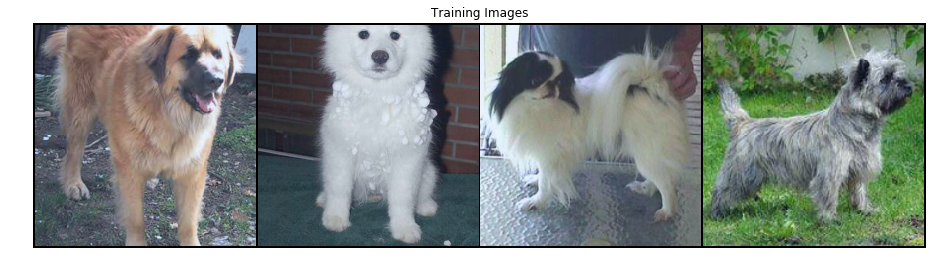

In [71]:
img, label = next(iter(train_dl))
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(img.to(device), padding=2, normalize=True).cpu(),(1,2,0)))
print(label)